In [39]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim 
import gzip
import json

## DONWLOAD MNSIT & VISUALIZE DATA
**Content**

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

Four files are available:
>

    train-images-idx3-ubyte.gz: training set images (9912422 bytes)
    train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
    t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
    t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)


In [26]:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  15.1M      0 --:--:-- --:--:-- --:--:-- 15.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  4441k      0 --:--:-- --:--:-- --:--:-- 4448k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  23817      0 --:--:-- --:--:-- --:--:-- 23905


In [3]:
image_size, num_tr_images, num_test_images = 28, 60000, 10000
out_size = 10

### TRAIN

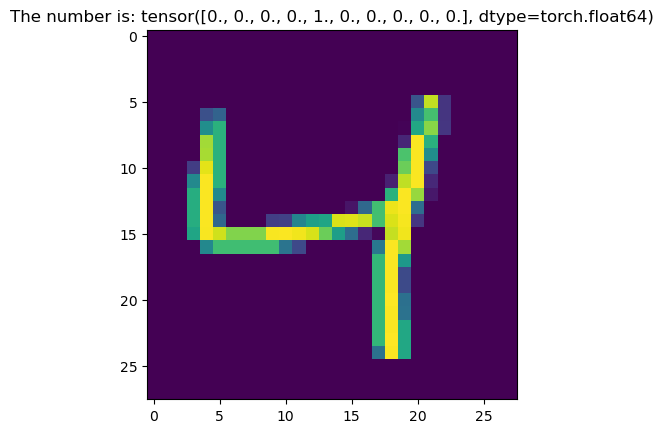

In [4]:
img_id = 2

# Label
f= gzip.open('train-labels-idx1-ubyte.gz')
f.read(8) # This line removes the header information.
buf = f.read(num_tr_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
Ytr = np.zeros(shape = (num_tr_images, out_size))
for id, dat in enumerate(data):
    Ytr[id][dat] = 1
Ytr = torch.tensor(Ytr)

# Image
f = gzip.open('train-images-idx3-ubyte.gz')
f.read(16) # This line removes the header information.
buf = f.read(image_size * image_size * num_tr_images)
Xtr = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
Xtr = Xtr.reshape(num_tr_images, image_size, image_size, 1)
image = np.asarray(Xtr[img_id]).squeeze()
Xtr = Xtr.transpose((0,3,1,2)) / 255
Xtr = torch.tensor(Xtr)

# Print
plt.title(f'The number is: {Ytr[img_id]}')
plt.imshow(image)


### TEST

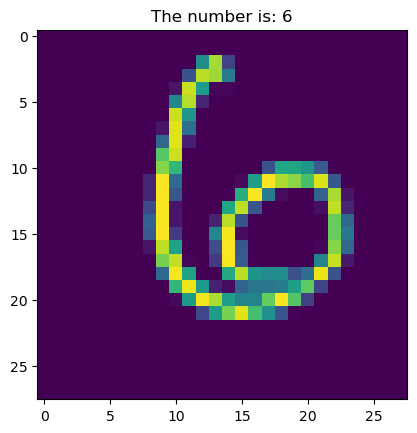

In [32]:
img_id = 100

# Label
f= gzip.open('t10k-labels-idx1-ubyte.gz')
f.read(8) # This line removes the header information.
buf = f.read(num_test_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)
Ytest = data

# Image
f = gzip.open('t10k-images-idx3-ubyte.gz')
f.read(16) # This line removes the header information.
buf = f.read(image_size * image_size * num_test_images)
Xtest = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
Xtest = Xtest.reshape(num_test_images, image_size, image_size, 1)
image = np.asarray(Xtest[img_id]).squeeze()
Xtest = Xtest.transpose((0,3,1,2)) / 255
Xtest = torch.tensor(Xtest)

# Print
plt.title(f'The number is: {Ytest[img_id]}')
plt.imshow(image)

## CREATING NN CLASS

In [58]:
class mnist_net(nn.Module):
    def __init__(self, img_sz, out_size):
        super(mnist_net, self).__init__()
        self.img_sz = img_sz
        # CNN 
        cnn_channels = [32, 64, 128]
        self.cnn_layers = [ 
                                [
                                    nn.Conv2d(in_channels = 1, out_channels = cnn_channels[0], kernel_size = 3, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features = cnn_channels[0]),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2)
                                ],
                                [
                                    nn.Conv2d(in_channels = cnn_channels[0], out_channels = cnn_channels[1], kernel_size = 3, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features = cnn_channels[1]),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2)
                                ],
                                [
                                    nn.Conv2d(in_channels = cnn_channels[1], out_channels = cnn_channels[2], kernel_size = 3, padding = 1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features = cnn_channels[2]),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2)
                                ],
                          ]
        # DNN 
        hidden_size = 1024
        out_x, x = None, torch.randn(1,1,*img_sz)
        for cnn_layer in self.cnn_layers:
            for i in range(len(cnn_layer)):
                out_x = cnn_layer[i](x)
                x = out_x
        out_x = out_x.view(out_x.shape[0], -1) # FLATTEN
        ip_sz = out_x.shape
        self.dnn_layers = [
                                [
                                    nn.Linear(in_features = ip_sz[-1], out_features = hidden_size), 
                                    nn.BatchNorm1d(num_features = hidden_size),
                                    nn.ReLU()
                                ],
                                [
                                    nn.Linear(in_features = hidden_size, out_features = out_size), 
                                    nn.Softmax(dim = 1)
                                ]

                            ]
        
    def forward(self, x):
        output = x 
        # CNN 
        for cnn_layer in self.cnn_layers:
            for i in range(len(cnn_layer)):
                output_tmp = cnn_layer[i](output)
                output = output_tmp
        # FLATTEN 
        output = output.view(output.shape[0], -1)
        # DNN 
        for dnn_layer in self.dnn_layers:
            for i in range(len(dnn_layer)):
                output_tmp = dnn_layer[i](output)
                output = output_tmp
        return output 
    
    def test_model(self):
        num_images = 1024
        x = torch.randn(num_images, 1, 28, 28)
        print(f'Input Shape: {x.shape}')
        res = self.forward(x)
        print(f'Output Shape: {res.shape}')
    
    def add_optimizer(self):
        # CNN 
        lr_param = []
        for cnn_layer in self.cnn_layers:
            for i in range(len(cnn_layer)):
                lr_param += list(cnn_layer[i].parameters()) 
        for dnn_layer in self.dnn_layers:
            for i in range(len(dnn_layer)):
                lr_param += list(dnn_layer[i].parameters())
        optimizer = optim.Adam(lr_param)
        return optimizer

    def save_model(self, id):
        cnn_lr_param = []
        for cnn_layer in self.cnn_layers:
            for i in range(len(cnn_layer)):
                cnn_lr_param += list(cnn_layer[i].parameters()) 
        dnn_lr_param = []
        for dnn_layer in self.dnn_layers:
            for i in range(len(dnn_layer)):
                dnn_lr_param += list(dnn_layer[i].parameters())
        print('SAVING MODEL...')
        torch.save(cnn_lr_param,  f'model/model_cnn{id}.ml')
        torch.save(dnn_lr_param, f'model/model_dnn{id}.ml')
        return [f'model/model_cnn{id}.ml', f'model/model_dnn{id}.ml']
        
    def load_model(self, name):
        print('LOADING MODEL...')
        wt_list = torch.load(f'{name[0]}')
        for cnn_layer in self.cnn_layers:
            for i in range(len(cnn_layer)):
                cnn_layer[i].weight = wt_list[i]
        wt_list = torch.load(f'{name[1]}')
        for dnn_layer in self.dnn_layers:
            for i in range(len(dnn_layer)):
                dnn_layer[i].weight = wt_list[i] 

## TESTING YOUR NN

In [24]:
obj = mnist_net(img_sz = (28,28), out_size = 10)
obj.test_model()

Input Shape: torch.Size([1024, 1, 28, 28])
Output Shape: torch.Size([1024, 10])


## TRAIN YOUR MODEL

In [25]:
batch_size = 128
epochs = 10 
train_val_split = 0.8
model = mnist_net(img_sz = (28, 28), out_size = 10)
optimizer = model.add_optimizer()
criterion = nn.CrossEntropyLoss()

# Shuffle data 
index = np.arange(Xtr.shape[0])
np.random.shuffle(index)
Xtr = Xtr[index]
Ytr = Ytr[index]

# Split data into train: validation
tr_len = int(Xtr.shape[0] * train_val_split)
Xtr, Xval = Xtr[:tr_len], Xtr[tr_len:]
Ytr, Yval = Ytr[:tr_len], Ytr[tr_len:]

In [26]:
# Validation function
def validate(model, Xval, Yval):
    model.eval()
    with torch.no_grad():
        lb, r_loss = 0, 0
        val_batch_size = 256
        criterion = nn.CrossEntropyLoss() 
        while lb + batch_size < Xval.shape[0]:
            Yp_val = model(Xval[lb: lb+val_batch_size])
            r_loss += criterion(Yp_val, Yval[lb: lb+val_batch_size]).item()
            lb += val_batch_size
        if lb < Xval.shape[0]:
            Yp_val = model(Xval[lb:])
            r_loss += criterion(Yp_val, Yval[lb:]).item()
        return r_loss / Xval.shape[0]

In [27]:
# TRAIN LOOP
tr_loss = []
val_loss = []

for epoch in range(epochs):
    lb, r_loss = 0, 0 
    while lb + batch_size < Xtr.shape[0]:
        Yp = model(Xtr[lb: lb+batch_size])
        optimizer.zero_grad()
        loss = criterion(Yp, Ytr[lb: lb+batch_size])
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
        lb += batch_size
    if lb < Xtr.shape[0]:
        Yp = model(Xtr[lb:])
        optimizer.zero_grad()
        loss = criterion(Yp, Ytr[lb:])
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
        tr_loss.append(r_loss/Xtr.shape[0])
    val_loss.append(validate(model, Xval, Yval))
    print(f'Epoch[{epoch}] ~ AvgLoss[{tr_loss[-1]}]')


Epoch[0] ~ AvgLoss[0.011749322352140249]
Epoch[1] ~ AvgLoss[0.011533572372506266]
Epoch[2] ~ AvgLoss[0.011496490546384545]
Epoch[3] ~ AvgLoss[0.01147463231166815]
Epoch[4] ~ AvgLoss[0.011463344303380533]
Epoch[5] ~ AvgLoss[0.011459896379680383]
Epoch[6] ~ AvgLoss[0.011457904396502272]
Epoch[7] ~ AvgLoss[0.011450358149037736]
Epoch[8] ~ AvgLoss[0.0114442826172611]
Epoch[9] ~ AvgLoss[0.011441446718830168]


## Saving and Loading Model

In [34]:
paths = model.save_model(id = 0)
model.load_model(paths)

## Testing Model.

In [33]:
with torch.no_grad():
    Yp_test = model(Xtest)
    labels = torch.argmax(Yp_test, dim = 1)
    acc = 0 
    for id, label in enumerate(labels):
        if label == Ytest[id]: acc += 1
    print(f'Test Accuracy [{acc*100/Xtest.shape[0]}]%')

Test Accuracy [99.05]


~~1. Implemnet load and save model.~~

2. Implement model.eval()

3. Implement early stopping.